<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebooks/SOM_Clustering_11th_July.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Authenticate with BigQuery ☁️**

In [ ]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]

      Successfully uninstalled six-1.12.0
  Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.1
  Found existing installation: google-cloud-core 1.0.3
    Uninstalling google-cloud-core-1.0.3:
      Successfully uninstalled google-cloud-core-1.0.3
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
  Found existing installation: google-cloud-bigquery 1.21.0
    Uninstalling google-cloud-bigquery-1.21.0:
      Successfully uninstalled google-cloud-bigquery-1.21.0


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api
SELECT 
  COUNT(*) as total_rows
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 

In [ ]:
df.head()

,total_rows
0,14841792


### **Importing Libraries⏬**

In [ ]:
!pip install MiniSom

  Created wheel for MiniSom: filename=MiniSom-2.2.6-cp36-none-any.whl size=8525 sha256=5bbb2199a66b9854f34ad30b26eb6da51092085c2560b882468ec3df8a43d5ea
  Stored in directory: /root/.cache/pip/wheels/b8/c6/01/330066e36e1f7c826c96f656f9185822cfcdef0591315949ea
Successfully built MiniSom


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm
from minisom import MiniSom
from datetime import date
from matplotlib.gridspec import GridSpec

sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Downloading Datasets 🚚**
Note - this can take a while to download!


In [ ]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api
SELECT 
*,
ROW_NUMBER() OVER (PARTITION BY lcl_id, month_name ORDER BY dayofweek ASC, hhourly_rank ASC) AS weekly_rank
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 
ORDER BY lcl_id, month_name ASC, dayofweek ASC, hhourly_rank ASC

In [ ]:
df.head()

,lcl_id,acorn_grouped,acorn,month_name,dayofweek,hhourly_rank,hh_avg,hh_max,hh_min,hh_stddev,hh_median,hh_quartile_25,hh_quartile_75,weekly_rank
0,MAC000003,Adversity,P,April,1,0,1.92100,3.416,1.409,0.996758,1.4295,1.41575,1.93475,1
1,MAC000003,Adversity,P,April,1,1,1.90075,3.334,1.403,0.955759,1.4330,1.40975,1.92400,2
2,MAC000003,Adversity,P,April,1,2,1.43775,3.051,0.691,1.088403,1.0045,0.85450,1.58775,3
3,MAC000003,Adversity,P,April,1,3,0.60825,2.175,0.069,1.044573,0.0945,0.08550,0.61725,4
4,MAC000003,Adversity,P,April,1,4,0.96275,2.653,0.356,1.127292,0.4210,0.39575,0.98800,5


### **Pivot Dataframe**

In [ ]:
def pivot_table(df):
    return pd.pivot_table(df, values=['hh_avg'], index=['lcl_id'], columns=['month_name','weekly_rank'], aggfunc=np.sum)
df_wide = pivot_table(df)
df_wide.columns = [''.join(str(col)) for col in df_wide.columns]

### **SOM clustering**

In [ ]:
def normalise_df(df):
    data = (df - np.mean(df, axis=0)) / np.std(df, axis=0)
    data = data.values
    return data 
data = normalise_df(df_wide)

In [ ]:
n_neurons = 5
m_neurons = 5
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(data)

/usr/local/lib/python3.6/dist-packages/minisom.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


In [ ]:
som.train(data, 50000, verbose=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 36.776523999639245


In [ ]:
som.topographic_error(data)

0.034773159467535994

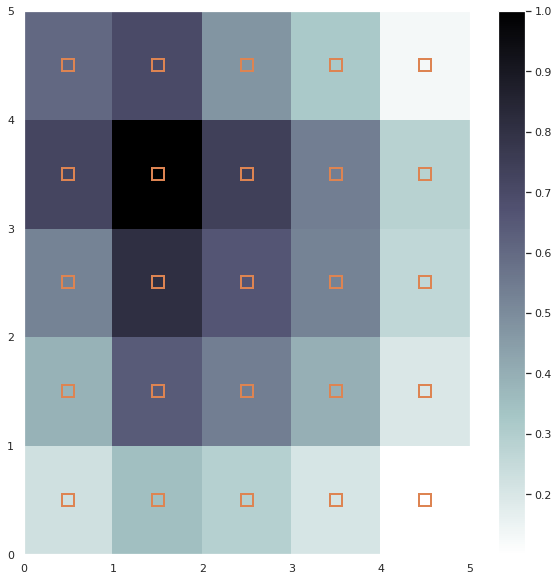

In [ ]:
acorn_grouped = df['acorn_grouped'].values

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
def return_markers(acorn):
    if acorn=="Comfortable":
        return 'o'
    elif acorn=="Adversity": 
        return 's'
    elif acorn=="Affluent":
        return 'D'
    else: return 'x'
def return_colours(acorn):
    if acorn=="Comfortable":
        return 'C0'
    elif acorn=="Adversity": 
        return 'C1'
    elif acorn == "Affluent":
        return 'C2'
    else: return 'C3'


for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, return_markers(acorn_grouped[cnt]), markerfacecolor='None',
             markeredgecolor=return_colours(acorn_grouped[cnt]), markersize=12, markeredgewidth=2)
plt.show()

In [ ]:
labels = df.groupby(['lcl_id','acorn_grouped']).count()
labels.reset_index(inplace=True)

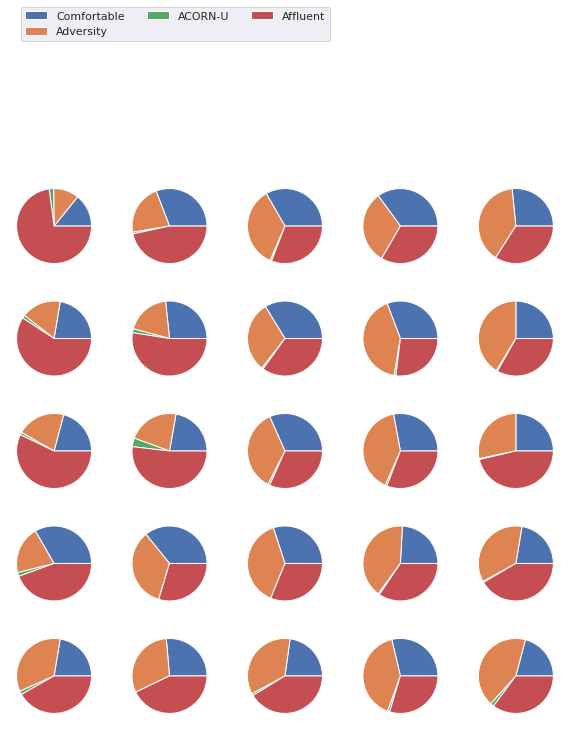

In [ ]:
import matplotlib.gridspec as gridspec
labels_map = som.labels_map(data, labels['acorn_grouped'])
label_names = list(set(labels['acorn_grouped']))

fig = plt.figure(figsize=(10, 10))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names, bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.show()

In [ ]:
clusters = pd.DataFrame(df_wide.index)
clusters['cluster_x'] = np.NaN
clusters['cluster_y'] = np.NaN

for i in tqdm(range(len(clusters))):
    bmu = som.winner(data[i])
    clusters.loc[i,'cluster_x'] = int(bmu[0])
    clusters.loc[i,'cluster_y'] = int(bmu[1])

100%|██████████| 3681/3681 [00:06<00:00, 562.59it/s]


In [ ]:
clusters.head()

,lcl_id,cluster_x,cluster_y
0,MAC000003,0.0,4.0
1,MAC000004,4.0,0.0
2,MAC000006,4.0,0.0
3,MAC000007,1.0,0.0
4,MAC000008,1.0,3.0


In [ ]:
cluster_df = clusters.merge(df, on='lcl_id')

In [ ]:
cluster_df.groupby(['cluster_x','cluster_y'])['lcl_id'].nunique()

cluster_x  cluster_y
0.0        0.0           67
           1.0           63
           2.0           91
           3.0           76
           4.0          155
1.0        0.0           91
           1.0           81
           2.0           54
           3.0          120
           4.0          133
2.0        0.0          114
           1.0          170
           2.0          120
           3.0          166
           4.0          159
3.0        0.0          108
           1.0          174
           2.0          136
           3.0          130
           4.0          117
4.0        0.0          603
           1.0          219
           2.0          244
           3.0          196
           4.0           94
Name: lcl_id, dtype: int64

In [ ]:
print(n_neurons, m_neurons)

5 5


### **Plot Clusters**

In [ ]:
def pick_random_lclids(df, num, position=None):
    """
    Function to pick random `num` lcl_ids from dataset
    Parameters:
        df : input dataframe 
        num: number of lcl_ids to output
    """
    if position is None:
        all_lcl_ids = list(set(df['lcl_id']))
    else:
        all_lcl_ids = list(set(df.query(f"cluster_x=={position[0]} and cluster_y=={position[1]}")['lcl_id']))
    
    return np.random.choice(all_lcl_ids, num, replace=False) 

def get_load_profile(df, lcl_id, month):
    return df.query((f"lcl_id=='{lcl_id}' and month_name == '{month}'"))[['weekly_rank','hh_avg']]

In [ ]:
def plot_clusters(cluster_df, month):
    print(f"\nPlotting load profiles for {month}\n")

    plt.figure(figsize=(48, 16))
    the_grid = GridSpec(n_neurons, m_neurons)

    for pos_i in tqdm(range(n_neurons)):
        for pos_j in range(m_neurons):
            plt.subplot(the_grid[pos_i, pos_j])
            lcl_ids = pick_random_lclids(cluster_df, 3, position=(pos_i,pos_j))
            for lcl_id in lcl_ids:
                load_profile = get_load_profile(cluster_df,lcl_id, month)
                plt.plot(load_profile['weekly_rank'], load_profile['hh_avg'], alpha=.5)


  0%|          | 0/5 [00:00<?, ?it/s]


Plotting load profiles for January



100%|██████████| 5/5 [00:47<00:00,  9.40s/it]


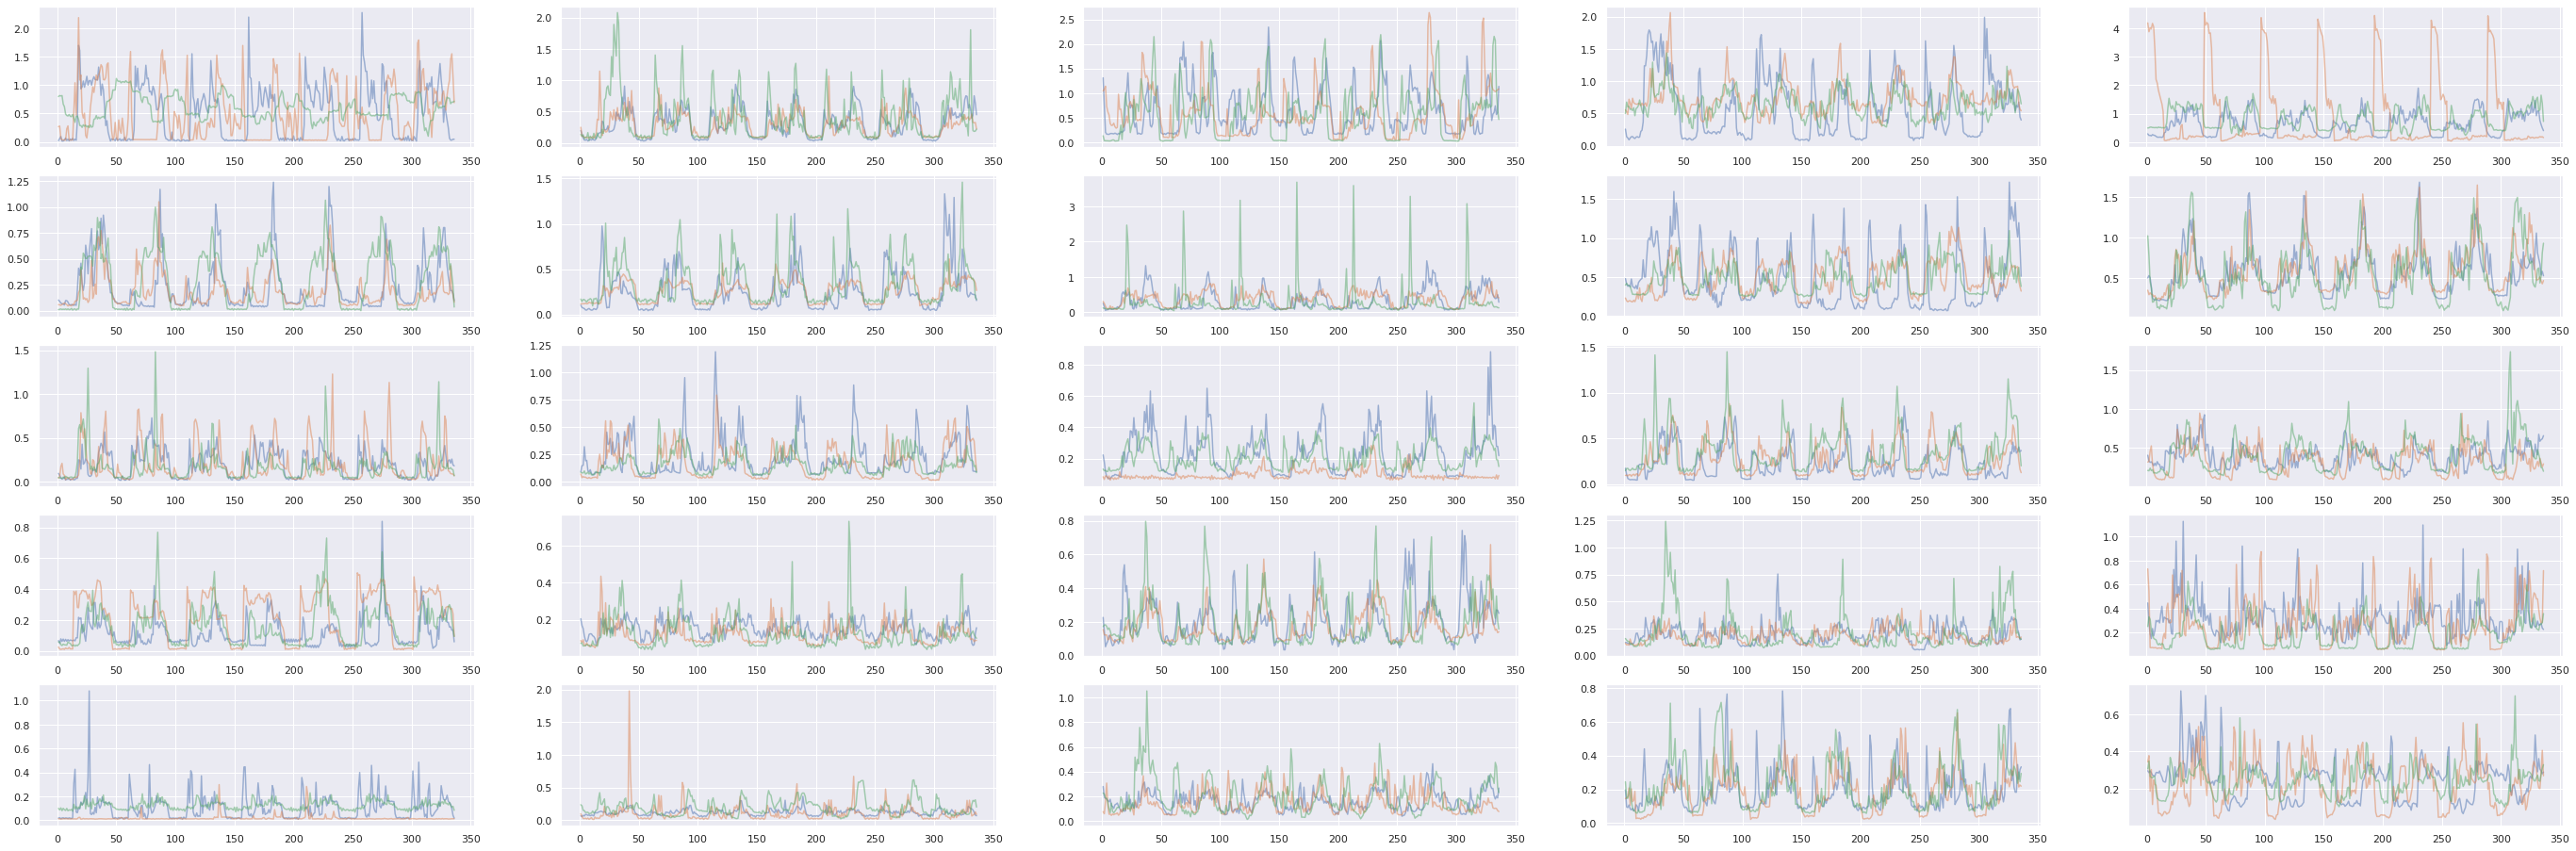

In [ ]:
plot_clusters(cluster_df, 'January')

  0%|          | 0/5 [00:00<?, ?it/s]


Plotting load profiles for March



100%|██████████| 5/5 [00:48<00:00,  9.73s/it]


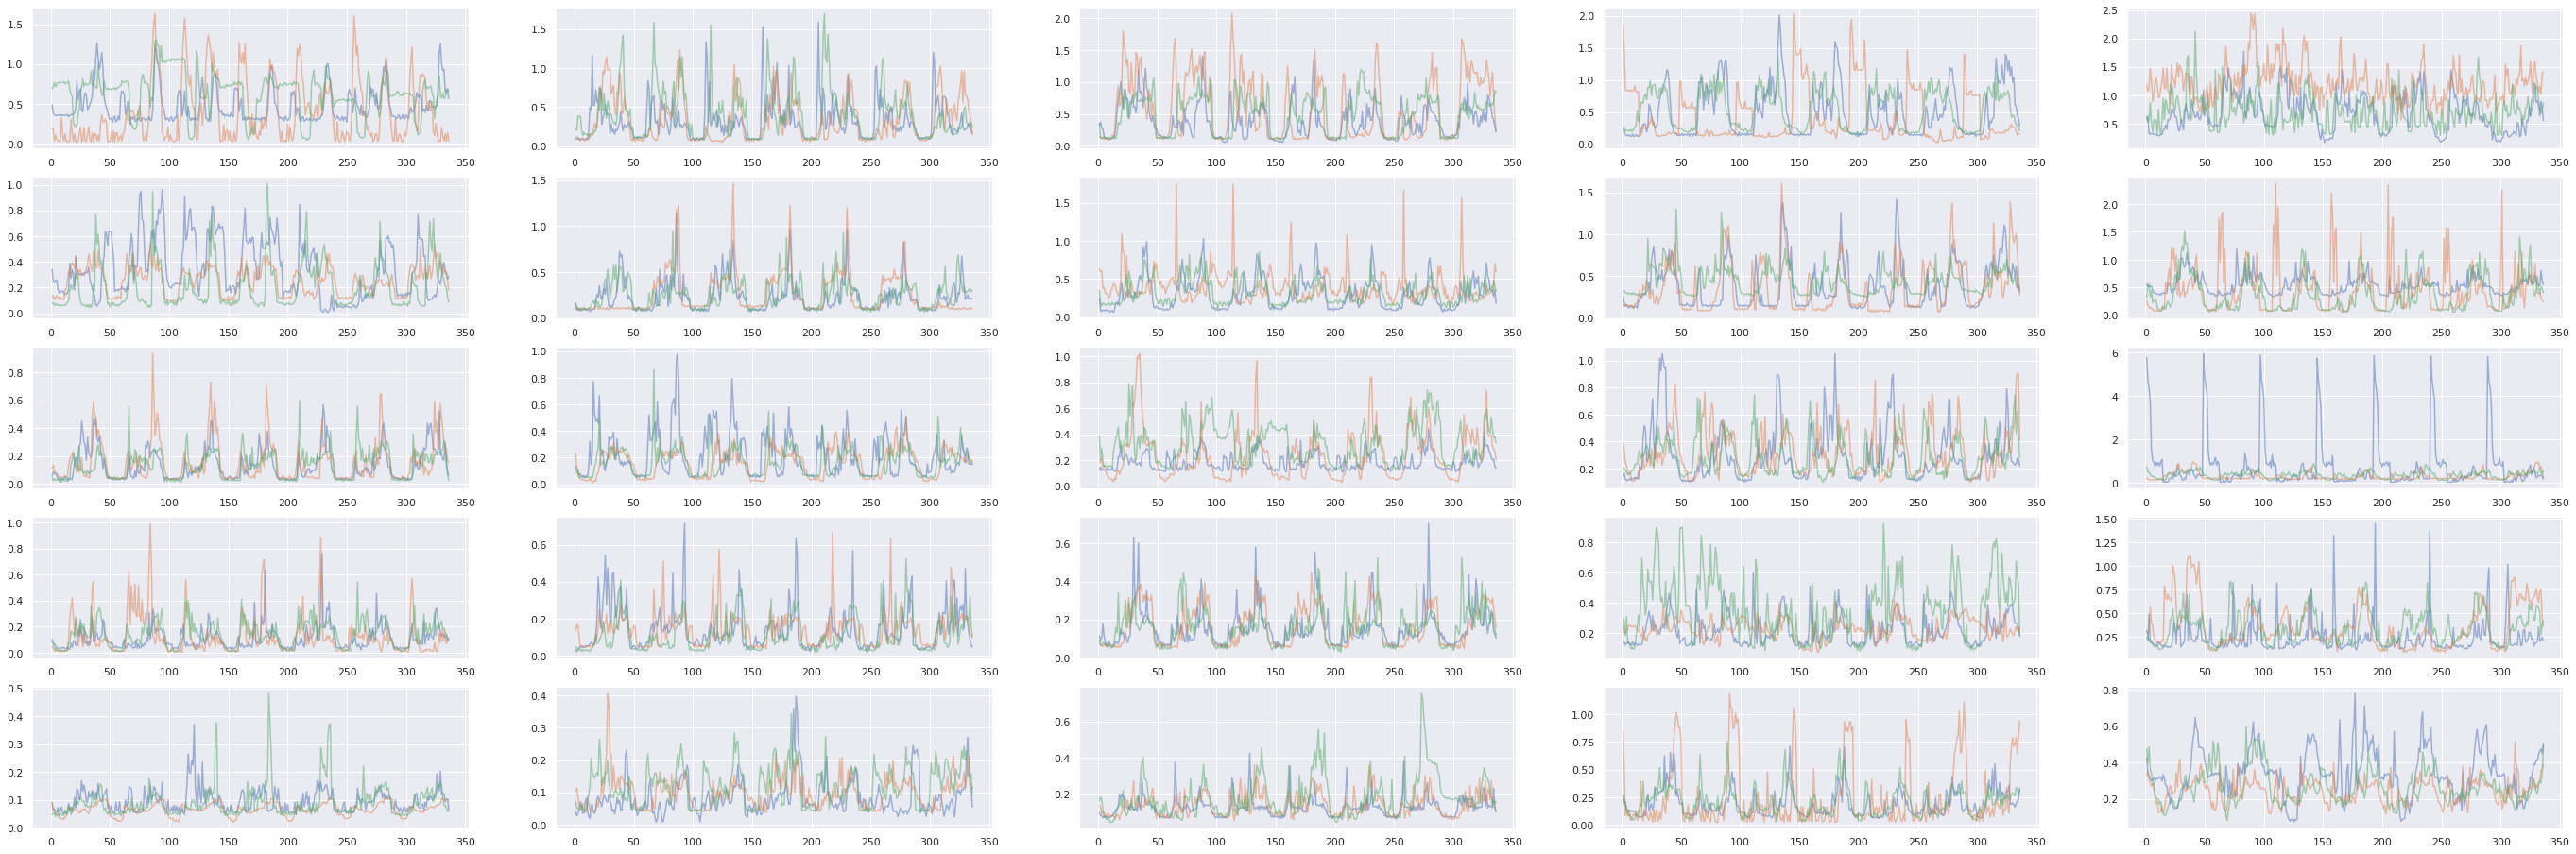

In [ ]:
plot_clusters(cluster_df, 'March')

  0%|          | 0/5 [00:00<?, ?it/s]


Plotting load profiles for September



100%|██████████| 5/5 [00:48<00:00,  9.63s/it]


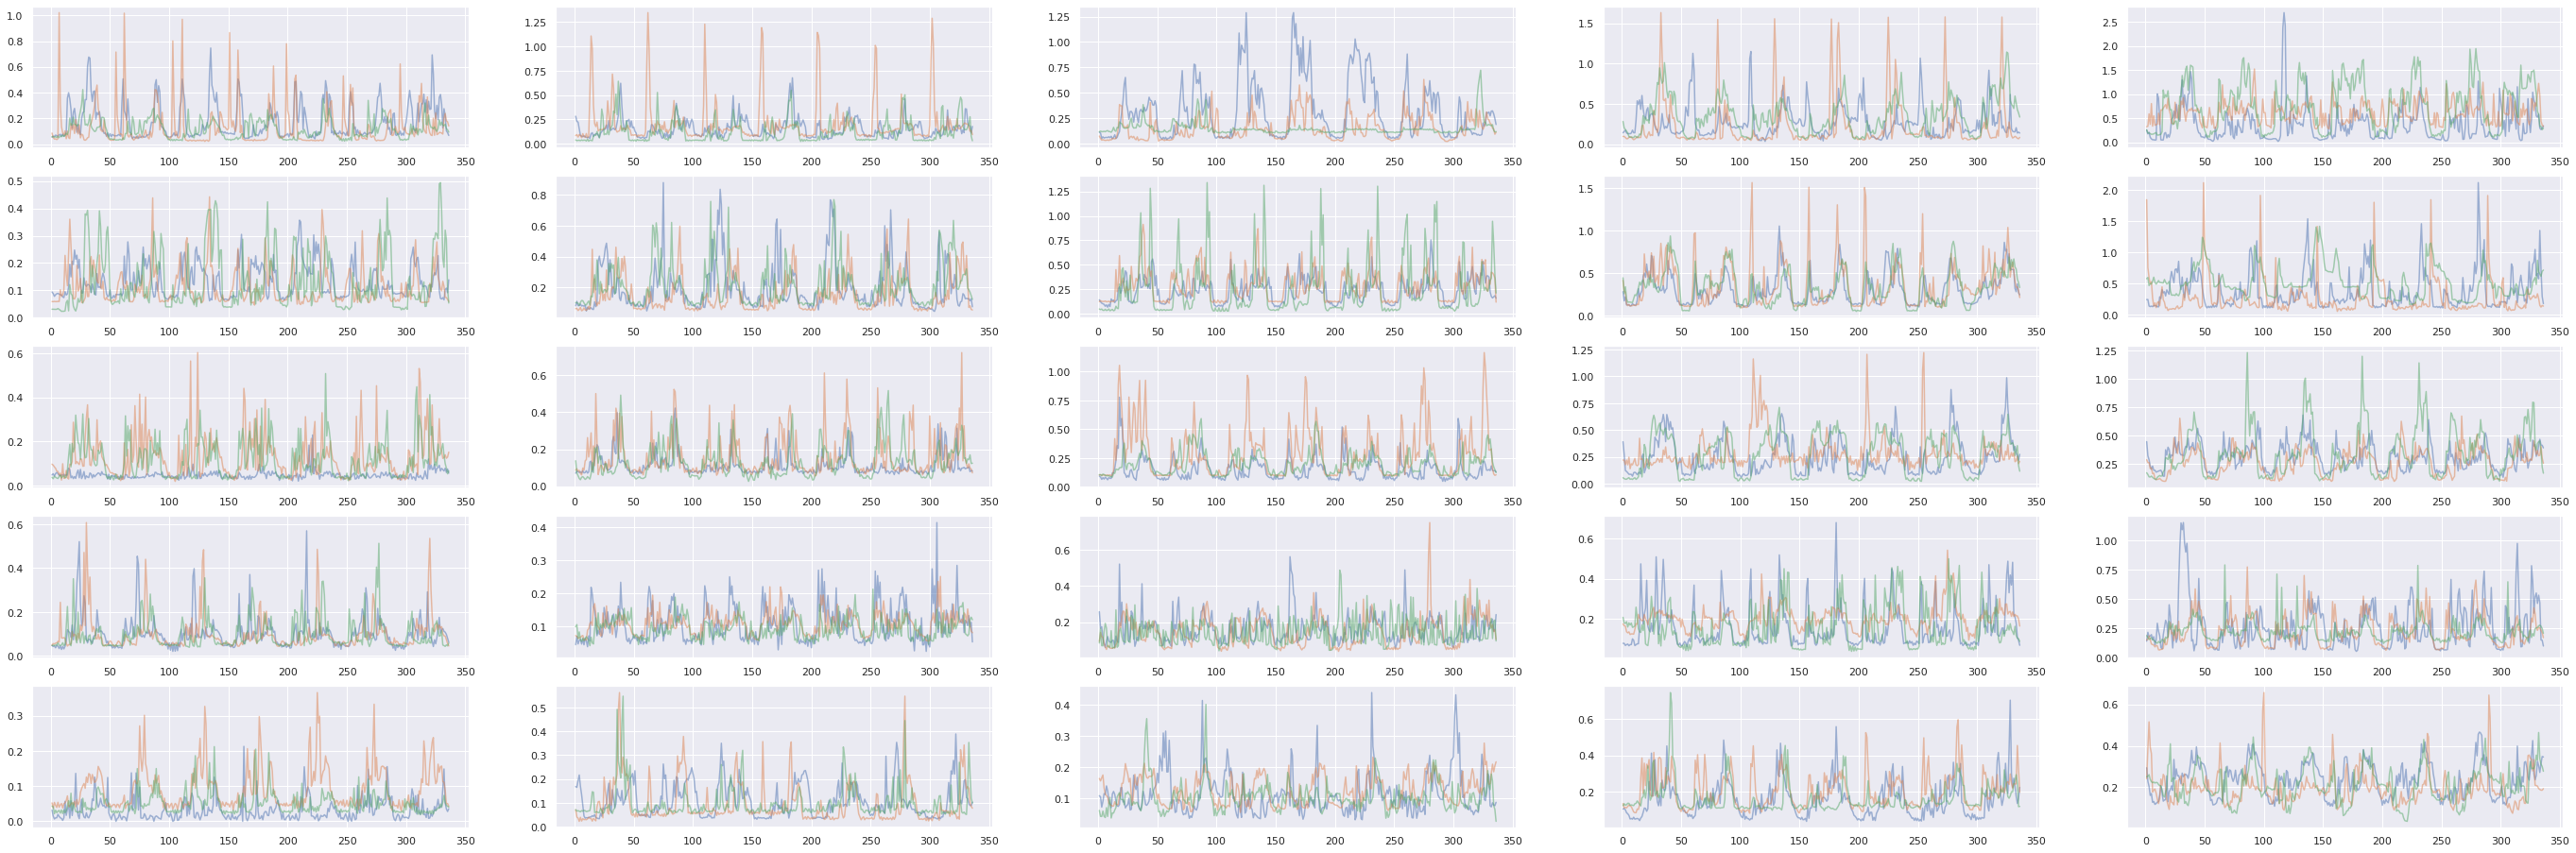

In [63]:
plot_clusters(cluster_df, 'September')

In [ ]:
x